# TinyMS LeNet5 教程

在本教程中，我们会演示使用TinyMS API构建LeNet5模型，下载数据集，训练，启动服务器和推理的过程。

## 环境要求
 - Ubuntu: `18.04`
 - Python: `3.7.x`
 - Flask: `1.1.2`
 - MindSpore: `CPU-1.1.1`
 - TinyMS: `0.1.0`
 - numpy: `1.17.5`
 - opencv-python: `4.5.1.48`
 - Pillow: `8.1.0`
 - pip: `21.0.1`
 - requests: `2.18.4`
 
## 介绍

TinyMS是一个高级API，目的是让新手用户能够更加轻松地上手深度学习。TinyMS可以有效地减少用户在构建、训练、验证和推理一个模型过程中的操作次数。TinyMS也提供了教程和文档帮助开发者更好的上手和开发。

本教程包括6部分，`构建模型`、`下载数据集`、`训练`，`定义servable json`, `启动服务器`和`推理`，其中服务器将在一个子进程中启动。

In [1]:
import os
import json
import tinyms as ts
import tinyms.optimizers as opt
from PIL import Image
from tinyms.data import MnistDataset, download_dataset
from tinyms.vision import mnist_transform
from tinyms.model import Model, lenet5
from tinyms.serving import start_server, predict, list_servables, shutdown, server_started
from tinyms.metrics import Accuracy
from tinyms.losses import SoftmaxCrossEntropyWithLogits

[WARNING] ME(24161:140155231090496,MainProcess):2021-03-16-17:18:24.520.614 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


### 1. 构建模型

TinyMS封装了MindSpore LeNet5模型中的init和construct函数，代码行数能够大大减少，原有的大量代码段行数会被极限压缩:

In [2]:
net = lenet5(class_num=10)

### 2. 下载数据集

如果根目录下没有创建`mnist`文件夹则MNIST数据集会被自动下载并存放到根目录，如果`mnist`文件夹已经存在于根目录 ，则此步操作会被跳过

In [3]:
# 下载数据集
mnist_path = '/root/mnist'
if not os.path.exists(mnist_path):
    ts.data.download_dataset('mnist', '/root')
    print('************Download complete*************')
else:
    print('************Dataset already exists.**************')

************Dataset already exists.**************


### 3. 训练模型

数据集中的训练集、验证集都会在此步骤中定义，同时也会定义训练参数。训练后生成的ckpt文件会保存到`/etc/tinyms/serving/lenet5`文件夹以便后续使用，训练完成后会进行验证并输出 `Accuracy`指标。

In [4]:
# 创建lenet路径
ckpt_folder = '/etc/tinyms/serving/lenet5'
ckpt_path = '/etc/tinyms/serving/lenet5/lenet5.ckpt'
if not os.path.exists(ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/lenet5
else:
    print('ckpt folder already exists')

# 定义训练和验证集
batch_size = 32
train_dataset = MnistDataset(os.path.join(mnist_path, "train"), shuffle=True)
train_dataset = mnist_transform.apply_ds(train_dataset)
eval_dataset = MnistDataset(os.path.join(mnist_path, "test"), shuffle=True)
eval_dataset = mnist_transform.apply_ds(eval_dataset)

# 训练的参数
lr = 0.01
momentum = 0.9
epoch_size = 3
net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = opt.Momentum(net.trainable_params(), lr, momentum)
net_metrics={"Accuracy": Accuracy()}

model = Model(net)
model.compile(loss_fn=net_loss, optimizer=net_opt, metrics=net_metrics)
print('************************Start training*************************')
model.train(epoch_size, train_dataset)
model.save_checkpoint(ckpt_path)
print('************************Finished training*************************')

model.load_checkpoint(ckpt_path)
print('************************Start evaluation*************************')
model.eval(eval_dataset)

[WARNING] ME(24161:140155231090496,MainProcess):2021-03-16-17:18:28.467.415 [mindspore/train/model.py:387] The CPU cannot support dataset sink mode currently.So the training process will be performed with dataset not sink.


ckpt folder already exists
************************Start training*************************


[WARNING] ME(24161:140155231090496,MainProcess):2021-03-16-17:20:11.761.244 [mindspore/train/model.py:712] CPU cannot support dataset sink mode currently.So the evaluating process will be performed with dataset non-sink mode.


************************Finished training*************************
************************Start evaluation*************************


{'Accuracy': 0.9833733974358975}

### 4. 定义servable.json

定义lenet5 servable json文件，Servable json文件定义了servable名称，模型名称，模型格式和分类数量，以便后续推理使用

In [5]:
servable_json = [{'name': 'lenet5', 
                  'description': 'This servable hosts a lenet5 model predicting numbers', 
                  'model': {
                      "name": "lenet5", 
                      "format": "ckpt", 
                      "class_num": 10}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 5. 启动服务器

#### 5.1 介绍
TinyMS推理是C/S（Client/Server）架构。TinyMS使用[Flask](https://flask.palletsprojects.com/en/1.1.x/)这个轻量化的网页服务器架构作为C/S通讯的基础架构。为了能够对模型进行推理，用户必须首先启动服务器。如果成功启动，服务器会在子进程中运行并且会监听从地址127.0.0.1，端口号5000发送来的POST请求并且使用MindSpore作为后端来处理这些请求。后端会构建模型，运行推理并且返回结果给客户端

#### 5.2 启动服务器

运行下列代码以启动服务器：

In [6]:
start_server()

Server starts at host 127.0.0.1, port 5000


### 6. 推理

#### 6.1 上传图片

用户需要上传一张0~9之间的数字图片作为输入。如果使用命令行终端，可以使用'scp'或者'wget'获取图片，如果使用Jupyter，点击菜单右上方的'Upload'按钮并且选择上传的图片。本教程中使用的图片可以点击[这里](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png)进行下载，将图片保存在根目录下，重命名为'7.png'（或者任何用户喜欢的名字）

或者运行如下的代码下载图片：

In [7]:
if not os.path.exists('/root/7.png'):
    !wget -P /root/ https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
else:
    print('7.png already exists')

--2021-03-16 17:20:19--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/tinyms-test-pics/numbers/7.png
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 121.36.121.44, 49.4.112.5, 49.4.112.113, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|121.36.121.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34970 (34K) [image/png]
Saving to: ‘/root/7.png’

7.png               100%[===================>]  34.15K  --.-KB/s    in 0.06s   

2021-03-16 17:20:19 (564 KB/s) - ‘/root/7.png’ saved [34970/34970]



#### 6.2 List servables

使用`list_servables`函数检查当前后端的serving模型

In [8]:
list_servables()

[{'description': 'This servable hosts a lenet5 model predicting numbers',
  'model': {'class_num': 10, 'format': 'ckpt', 'name': 'lenet5'},
  'name': 'lenet5'}]

如果输出的`description`字段显示这是一个`lenet5`的模型，则可以继续到下一步发送推理请求

#### 6.3 发送推理请求

运行`predict`函数发送推理请求，第4个参数选择`TOP1_CLASS`或者`TOP5_CLASS`输出:

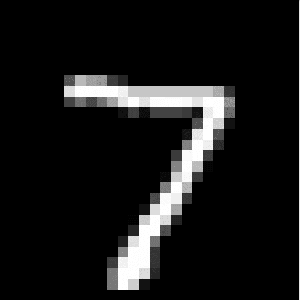

TOP1: 7, score: 0.99914157390594482422


In [9]:
# 设置图片路径和输出策略（可以在TOP1和TOP5中选择）
image_path = "/root/7.png"
strategy = "TOP1_CLASS"

# predict(image_path, servable_name, dataset='mnist', strategy='TOP1_CLASS')
# predict方法的四个参数分别是图片路径、servable名称，数据集名称（默认MNIST）和输出策略（默认输出TOP1，可以选择TOP5）
if server_started() is True:
    display(Image.open(image_path).resize((300, 300), Image.ANTIALIAS))
    print(predict(image_path,'lenet5', 'mnist', strategy))
else:
    print("Server not started")

如果用户能看到类似如下输出:  
```
TOP1: 7, score: 0.99934917688369750977
```  
那么意味着已经进行了一次成功的推理

## 关闭服务器

运行以下代码关闭服务器：

In [10]:
shutdown()

'Server shutting down...'